In [9]:
from lib.measurement import MultiQubitMeasurement
from lib.formatting import format_bytes, bitstring_to_filestring

####

from pathlib import Path

import netket as nk
from netket.operator import LocalOperator, Ising, spin
from netket.hilbert import AbstractHilbert, Spin
from netket.graph import Graph, Hypercube

import jax
import jax.numpy as jnp
from jax import random

import numpy as np

from scipy.sparse.linalg import eigsh

In [10]:
rng_seed = 42

data_dir = Path("data")
data_dir.mkdir(parents=True, exist_ok=True)

print(f"Random seed is {rng_seed}")
print(f"Data will be saved to {data_dir.resolve()}")

Random seed is 42
Data will be saved to /Users/Tonni/Desktop/master-code/neural-quantum-tomo/case_studies/tfim/data


<Axes: >

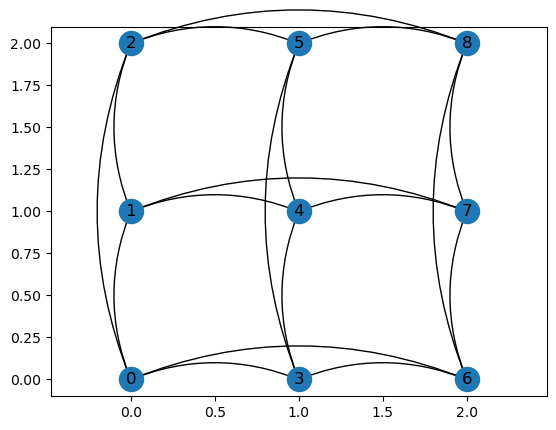

In [11]:
# define interactions on a 2D square lattice with periodic boundary conditions

side_length = 3
interaction_graph = Hypercube(length=side_length, n_dim=2, pbc=True)
interaction_graph.draw()

In [12]:
# define spin 1/2 Hilbert Space to perform our calculations in

hilbert_space = Spin(s=0.5, N=interaction_graph.n_nodes)

# define the TFIM Hamiltonian using NetKet's Ising operator
J = -1.0  # ferromagnetic coupling
h = 7.0  # transverse field strength
# 2.0, 2.5, 2.8, 2.9, 3.0, 3.1, 3.2, 3.5, 4.0 OLD
# [1.0, 2.0, 2.8, 3.0, 3.3, 3.6, 4.0, 5.0, 6.0, 7.0]


tfim_hamiltonian = Ising(hilbert_space, interaction_graph, h=h, J=J)

In [13]:
# define it by hand as double check

def construct_tfim_hamiltonian(
        hilbert: AbstractHilbert,
        graph: Graph,
        h: float,
        J: float = 1.0) -> LocalOperator:

    tfim_hamiltonian = LocalOperator(hilbert)

    # per-site interaction with transverse field
    for site in graph.nodes():
        tfim_hamiltonian += -h * spin.sigmax(hilbert, site)


    # nearest-neighbour coupling
    for site_i, site_j in graph.edges():
        site_i_coupling = spin.sigmaz(hilbert, site_i)
        site_j_coupling = spin.sigmaz(hilbert, site_j)
        tfim_hamiltonian += J * (site_i_coupling @ site_j_coupling)

    return tfim_hamiltonian


#### compare

manual = construct_tfim_hamiltonian(hilbert_space, interaction_graph, h=h, J=J)
builtin = nk.operator.Ising(hilbert_space, interaction_graph, h=h, J=J)

manual_sparse = manual.to_sparse()
builtin_sparse = builtin.to_sparse()

# Compare: elementwise squared difference
diff = manual_sparse - builtin_sparse
squared_error = (diff @ diff).diagonal().sum()

assert squared_error < 1e-10, "Hamiltonians are not equivalent!"

In [14]:
def calculate_groundstate(hamiltonian: LocalOperator) -> tuple[float, jnp.ndarray]:

    num_eigenvalues = 1
    type_eigenvalue = 'SA'  # smallest algebraic eigenvalue

    eigvals, eigvecs = eigsh(hamiltonian.to_sparse(), k=num_eigenvalues, which=type_eigenvalue)
    ground_state_energy = eigvals[0]
    state_vector = eigvecs[:, 0]
    return ground_state_energy, jnp.array(state_vector, dtype=jnp.complex64)


# get our state vector

_, tfim_state = calculate_groundstate(tfim_hamiltonian)

num_qubits = interaction_graph.n_nodes

print("First 10 amplitudes:")
for idx in range(10):
    print(f"{idx:0{num_qubits}b}: {tfim_state[idx]:.8f}")

print(f"\nSize of state vector in memory: {format_bytes(tfim_state.nbytes)} \n")

First 10 amplitudes:
000000000: -0.08880263+0.00000000j
000000001: -0.06442785+0.00000000j
000000010: -0.06442785+0.00000000j
000000011: -0.05410856+0.00000000j
000000100: -0.06442785+0.00000000j
000000101: -0.05410856+0.00000000j
000000110: -0.05410856+0.00000000j
000000111: -0.05276332+0.00000000j
000001000: -0.06442785+0.00000000j
000001001: -0.05410856+0.00000000j

Size of state vector in memory: 4.00 KB 



In [15]:
file_name = f"tfim_h{h:.2f}_{side_length}x{side_length}.txt"
np.savetxt(data_dir / file_name, np.real(tfim_state))
basis_comp = ['Z'] * num_qubits
measurement = MultiQubitMeasurement(basis_comp)


Constructing basis ZZZZZZZZZ: 100%|██████████| 512/512 [00:00<00:00, 2280.99it/s]


In [16]:

num_samples_comp = 10_000
batch_size = 1000
num_batches = num_samples_comp // batch_size
rng_comp = random.PRNGKey(rng_seed + 1)

basis_comp_str = ''.join(basis_comp)
filename_comp = f"tfim_h{h:.2f}_{side_length}x{side_length}_{num_samples_comp}.txt"
filepath_comp = data_dir / filename_comp

with open(filepath_comp, "w") as f:
    for i in range(num_batches):
        rng_comp, rng_step = jax.random.split(rng_comp)
        samples = measurement.sample_state(tfim_state, batch_size, rng=rng_step)

        for sample in samples:
            f.write(bitstring_to_filestring(sample, basis_comp) + "\n")

        print(f"Wrote batch {i+1}/{num_batches} ({(i+1)*batch_size} samples)")

Wrote batch 1/10 (1000 samples)
Wrote batch 2/10 (2000 samples)
Wrote batch 3/10 (3000 samples)
Wrote batch 4/10 (4000 samples)
Wrote batch 5/10 (5000 samples)
Wrote batch 6/10 (6000 samples)
Wrote batch 7/10 (7000 samples)
Wrote batch 8/10 (8000 samples)
Wrote batch 9/10 (9000 samples)
Wrote batch 10/10 (10000 samples)
